In [1]:
from g2s.models.geometry_2_sphere import Mesh2Drag
from g2s.datasets.drag_dataset import DragDataset as E3DragDataset
from g2s.datasets.transformer_drag_dataset import DragDataset, transformer_collate_function
from g2s.datasets.transforms.general import Compose
from g2s.datasets.transforms.radar import Log, Abs, Normalize, Center
from g2s.datasets.transforms.mesh import MeshNormalize

import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as TorchDataLoader
import xarray
import torch
from torch import nn
from pathlib import Path

from hydra_zen import load_from_yaml, instantiate, get_target
from mlflow import MlflowClient, set_tracking_uri

In [2]:
set_tracking_uri('geometry2sphere/datasets/out/mlflow')
runs = MlflowClient().search_runs(
    experiment_ids="429858339920414921",
)

In [ ]:
output_dir = runs[0].data.params['output_dir']
print(output_dir)
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
transformer = get_target(cfg.module)
transformer = transformer.load_from_checkpoint(
    output_dir + '/last.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

In [ ]:
output_dir = runs[2].data.params['output_dir']
print(output_dir)
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
equiformer = get_target(cfg.module)
equiformer = equiformer.load_from_checkpoint(
    output_dir + '/model_epoch=3.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

In [ ]:
output_dir = runs[3].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
o2s = get_target(cfg.module)
o2s = o2s.load_from_checkpoint(
    output_dir + '/last.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

In [6]:
output_dir = runs[3].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
test_ds_fp = 'geometry2sphere/datasets/drag_sweep/'
ds = E3DragDataset(
    test_ds_fp,
    'train',
    seed=0,
    transform=instantiate(cfg.test_dataset.transform),
    shuffle_before_split=False,
    testing=True
)

In [7]:
e3_dl = DataLoader(ds, batch_size=430, num_workers=0, shuffle=False)
e3_itr = iter(e3_dl)

In [8]:
mesh, flight_conds, coords, drag = next(e3_itr)

In [31]:
with torch.no_grad():
    equiformer_pred, _ = equiformer((mesh.cuda(), flight_conds.cuda(), coords.cuda()))
    o2s_pred, w = o2s((mesh.cuda(), flight_conds.cuda(), coords.cuda()))

torch.Size([430, 1, 36, 1, 1])


In [17]:
output_dir = runs[0].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
test_ds_fp = 'geometry2sphere/datasets/drag_sweep/'
ds = DragDataset(
    test_ds_fp,
    'train',
    seed=0,
    transform=instantiate(cfg.test_dataset.transform),
    shuffle_before_split=False,
    testing=True
)

In [22]:
dl = TorchDataLoader(ds, batch_size=430, num_workers=0, shuffle=False, collate_fn=transformer_collate_function)
itr = iter(dl)

In [23]:
data = next(itr)
for k,v in data.items():
    data[k] = v.cuda()

In [24]:
with torch.no_grad():
    transformer_pred, _ = transformer(data)

Text(0, 0.5, 'Angle of side slip [deg]')

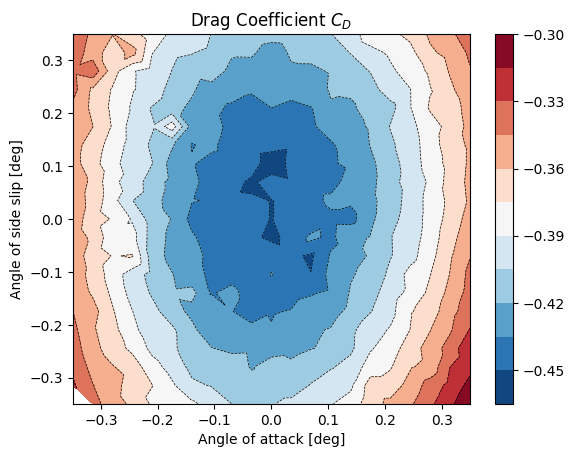

In [13]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
z = o2s_pred.cpu().squeeze().numpy()

fig, ax1, = plt.subplots(nrows=1)
ax1.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax1.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax1)
ax1.set_title(r'Drag Coefficient $C_D$')
#jax1.set(xlim=(0, 20), ylim=(0, 20))  # just 0 to 20 b/c of symmetry
ax1.set_xlabel(r'Angle of attack [deg]')
ax1.set_ylabel(r'Angle of side slip [deg]')

Text(0, 0.5, 'Angle of side slip [deg]')

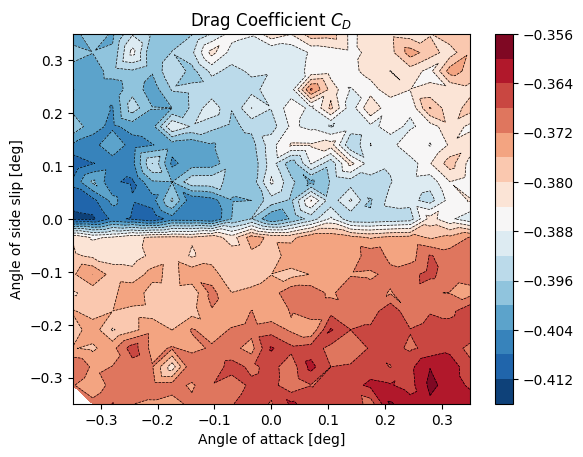

In [14]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
z = equiformer_pred.cpu().squeeze().numpy()

fig, ax1, = plt.subplots(nrows=1)
ax1.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax1.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax1)
ax1.set_title(r'Drag Coefficient $C_D$')
#jax1.set(xlim=(0, 20), ylim=(0, 20))  # just 0 to 20 b/c of symmetry
ax1.set_xlabel(r'Angle of attack [deg]')
ax1.set_ylabel(r'Angle of side slip [deg]')

Text(0, 0.5, 'theta')

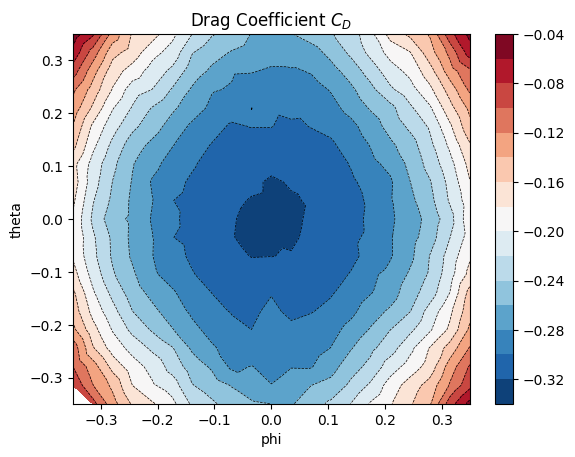

In [15]:
z = drag.cpu().squeeze()

fig, ax1, = plt.subplots(nrows=1)
ax1.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax1.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax1)
ax1.set_title(r'Drag Coefficient $C_D$')
#jax1.set(xlim=(0, 20), ylim=(0, 20))  # just 0 to 20 b/c of symmetry
ax1.set_xlabel(r'phi')
ax1.set_ylabel(r'theta')

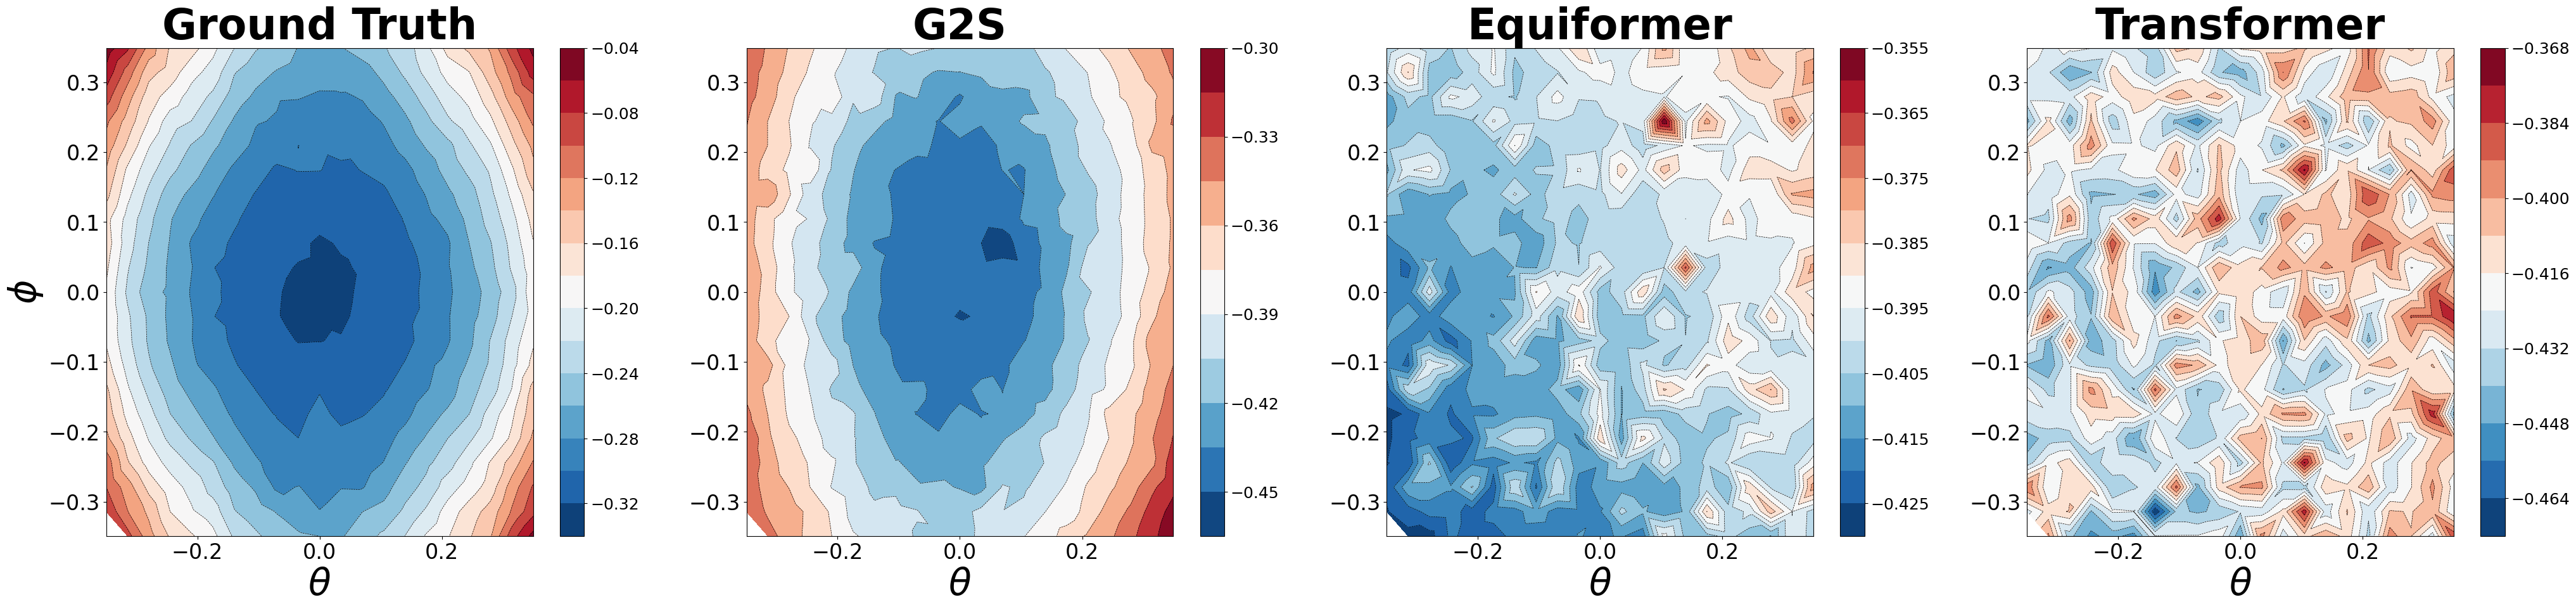

In [65]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
        
z0 = drag.cpu().squeeze().numpy()
z1 = o2s_pred.cpu().squeeze().numpy()
z2 = equiformer_pred.cpu().squeeze().numpy()
z3 = transformer_pred.cpu().squeeze().numpy()

fig, ax, = plt.subplots(ncols=4, figsize=(50,10))
ax[0].tricontour(x, y, z0, levels=14, linewidths=0.5, colors='k')
cntr_gt = ax[0].tricontourf(x, y, z0, levels=14, cmap="RdBu_r")

ax[1].tricontour(x, y, z1, levels=14, linewidths=0.5, colors='k')
cntr_g2s = ax[1].tricontourf(x, y, z1, levels=14, cmap="RdBu_r")

ax[2].tricontour(x, y, z2, levels=14, linewidths=0.5, colors='k')
cntr_equi = ax[2].tricontourf(x, y, z2, levels=14, cmap="RdBu_r")

ax[3].tricontour(x, y, z3, levels=14, linewidths=0.5, colors='k')
cntr_trans = ax[3].tricontourf(x, y, z3, levels=14, cmap="RdBu_r")

f1= 48
f2 = 42
f3 = 24
f4 = 18
cb1 = fig.colorbar(cntr_gt, ax=ax[0])
ax[0].set_title(r'Ground Truth', fontsize=f1, fontweight='bold')
ax[0].set_xlabel(r'$\theta$', fontsize=f2)
ax[0].set_ylabel(r'$\phi$', fontsize=f2)
ax[0].xaxis.set_tick_params(labelsize=f3)
ax[0].yaxis.set_tick_params(labelsize=f3)
cb1.ax.tick_params(labelsize=f4) 

cb2 = fig.colorbar(cntr_g2s, ax=ax[1])
ax[1].set_title(r'G2S', fontsize=f1, fontweight='bold')
ax[1].set_xlabel(r'$\theta$', fontsize=f2)
ax[1].xaxis.set_tick_params(labelsize=f3)
ax[1].yaxis.set_tick_params(labelsize=f3)
cb2.ax.tick_params(labelsize=f4) 

cb3 = fig.colorbar(cntr_equi, ax=ax[2])
ax[2].set_title(r'Equiformer', fontsize=f1, fontweight='bold')
ax[2].set_xlabel(r'$\theta$', fontsize=f2)
ax[2].xaxis.set_tick_params(labelsize=f3)
ax[2].yaxis.set_tick_params(labelsize=f3)
cb3.ax.tick_params(labelsize=f4) 

cb4 = fig.colorbar(cntr_trans, ax=ax[3])
ax[3].set_title(r'Transformer', fontsize=f1, fontweight='bold')
ax[3].set_xlabel(r'$\theta$', fontsize=f2)
ax[3].xaxis.set_tick_params(labelsize=f3)
ax[3].yaxis.set_tick_params(labelsize=f3)
cb4.ax.tick_params(labelsize=f4) 

plt.savefig('drag_compare.png')